
<h1 id="Tutorial-5---Three-way-branch-migration-energies">Tutorial 5 - Three-way branch migration energies<a class="anchor-link" href="#Tutorial-5---Three-way-branch-migration-energies">¶</a></h1>



<p>This example walks you through how to create multistranded complexes, how to find their energies, and how to find the energy of a test tube state with multiple complexes at a chosen concentration (i.e. box volume).  The example is toehold-initiated three-way branch migration, as per Zhang &amp; Winfree, JACS, 2009.  Some things are done in a rather long-winded way, just to illustrate the use of Multistrand.  The intention is for you to try it line by line, and play around a bit.  E.g. use print() and help().</p>


In [1]:
from multistrand.objects import *
from multistrand.options import Options, EnergyType
from multistrand.system import *

In [2]:
o = Options()
o.dangles = 1                # 0 is "None", 1 is "Some", 2 is "All".  You can use the string names only when passing as arguments to Options().
o.temperature = 25           # values between 0 and 100 are assumed to be Celsius; between 273.15 and 373.0 are assumed to be Kelvin.
o.join_concentration = 1e-9  # the volume is scaled such that a single strand is at 1 nM concentration.  
o.DNA23Metropolis()

In [3]:
# Sequences are from Zhang & Winfree, JACS 2009.
toe = Domain(name='toehold', sequence='TCTCCATGTC')
bm = Domain(name='branch', sequence='CCCTCATTCAATACCCTACG')
extra = Domain(name='extra', sequence='CCACATACATCATATT')

In [4]:
substrate = toe.C + bm.C   # this.C computes the Watson-Crick complement; this + that combines Domains (or Strands) into a larger Strand.
substrate.name = "Substrate"
invasion = substrate.C
incumbent = extra + bm
incumbent.name = "Incumbent"

In [5]:
# Example showing that the reference state energy (all strands separate, unstructured) is defined to be 0.
c1 = Complex(strands=[incumbent], structure='.'*len(incumbent.sequence))
c2 = Complex(strands=[invasion], structure='.'*len(invasion.sequence))
c3 = Complex(strands=[substrate], structure='.'*len(substrate.sequence))
ref = calculate_energy([c1,c2,c3], o, EnergyType.tube)  # gives all zeros

In [6]:
# Example secondary structure in dot-paren notation, showing invading strand bound by the 10-nt toehold only.
# The two commands below are equivalent.  One gives the structure at the domain level, the other at the sequence level.
c = Complex(strands=[incumbent,invasion,substrate], structure=".(+.(+))")
c = Complex(strands=[incumbent,invasion,substrate],
            structure="................((((((((((((((((((((+....................((((((((((+))))))))))))))))))))))))))))))")

In [7]:
# Another way to write the above dot-paren secondary structure:
st = "................" + 20 * "(" + "+" + 20*"." + "((((((((((+))))))))))" + 20 * ")"

In [8]:
print("<------- incumbent strand ---------> <------ invasion strand -----> <----- substrate strand ----->  (energy in kcal/mol)")
print(incumbent.sequence + ' ' + invasion.sequence + ' ' + substrate.sequence)

print("initial state")
c1 = Complex(strands=[invasion], structure='.'*len(invasion.sequence))
st = "................((((((((((((((((((((+..........))))))))))))))))))))"
st = '.' * 16 + '(' * 20 + '+' + '.' * 10 + ')' * 20
c2 = Complex(strands=[incumbent,substrate], structure=st)
before = sum(calculate_energy([c1,c2], o, EnergyType.tube))
# awkward wrap for indicating complexes on one line without permuting strand order
print(f"{st[:36]} {'.'*30} {st[37:]}+ ({before:5.2f})")

<------- incumbent strand ---------> <------ invasion strand -----> <----- substrate strand ----->  (energy in kcal/mol)
CCACATACATCATATTCCCTCATTCAATACCCTACG CCCTCATTCAATACCCTACGTCTCCATGTC GACATGGAGACGTAGGGTATTGAATGAGGG
initial state
................(((((((((((((((((((( .............................. ..........))))))))))))))))))))+ (-18.04)


In [9]:
# Then we'll compute the energies for states as the toehold is binding, one base pair at a time.
print("toehold binding")

toeh = []
for i in range(9, -1, -1):
    te = "................((((((((((((((((((((+...................." + (10-i)* "(" + i*"." + "+" + i*"." + (10-i)* ")" + "))))))))))))))))))))"
    c = Complex(strands=[incumbent,invasion,substrate], structure=te)
    e = calculate_energy([c], o, EnergyType.tube)[0]
    toeh.append(e)
    print(f"{te}  ({e:6.2f})")

toehold binding
................((((((((((((((((((((+....................(.........+.........)))))))))))))))))))))  ( -2.79)
................((((((((((((((((((((+....................((........+........))))))))))))))))))))))  ( -5.24)
................((((((((((((((((((((+....................(((.......+.......)))))))))))))))))))))))  ( -5.88)
................((((((((((((((((((((+....................((((......+......))))))))))))))))))))))))  ( -8.02)
................((((((((((((((((((((+....................(((((.....+.....)))))))))))))))))))))))))  (-10.80)
................((((((((((((((((((((+....................((((((....+....))))))))))))))))))))))))))  (-11.22)
................((((((((((((((((((((+....................(((((((...+...)))))))))))))))))))))))))))  (-12.65)
................((((((((((((((((((((+....................((((((((..+..))))))))))))))))))))))))))))  (-15.26)
................((((((((((((((((((((+....................(((((((((.+.)))))))))))))))))))))))))))))  (-15.81)
...

In [10]:
# Then we'll compute the energies for the three-stranded complex during branch migration steps and toehold binding steps
print("branch migration")

primary = []   # structures with full base-pairing
intermed = []  # structures with one base-pair open
for i in range(20):
    st = "................" + (20-i) * "(" + i*"." + "+" + (20-i)*"." + i*"(" + "((((((((((+))))))))))" + 20 * ")"
    c = Complex(strands=[incumbent,invasion,substrate], structure=st)
    e = calculate_energy([c], o, EnergyType.tube)[0]
    primary.append(e)
    print(f"{st}  ({e:6.2f})")

    if i<19:
        st_int = "................" + (19-i) * "(" + (i+1)*"." + "+" + (20-i)*"." + i*"(" + "((((((((((+))))))))))" + i * ")" + "." + (19-i) * ")"
        c = Complex(strands=[incumbent,invasion,substrate], structure=st_int)
        e = calculate_energy([c], o, EnergyType.tube)[0]
        intermed.append(e)
        print(f"{st_int}  ({e:6.2f})")

branch migration
................((((((((((((((((((((+....................((((((((((+))))))))))))))))))))))))))))))  (-16.86)
................(((((((((((((((((((.+....................((((((((((+)))))))))).)))))))))))))))))))  (-14.98)
................(((((((((((((((((((.+...................(((((((((((+))))))))))))))))))))))))))))))  (-17.12)
................((((((((((((((((((..+...................(((((((((((+))))))))))).))))))))))))))))))  (-14.83)
................((((((((((((((((((..+..................((((((((((((+))))))))))))))))))))))))))))))  (-17.87)
................(((((((((((((((((...+..................((((((((((((+)))))))))))).)))))))))))))))))  (-18.93)
................(((((((((((((((((...+.................(((((((((((((+))))))))))))))))))))))))))))))  (-19.34)
................((((((((((((((((....+.................(((((((((((((+))))))))))))).))))))))))))))))  (-18.85)
................((((((((((((((((....+................((((((((((((((+))))))))))))))))))))))))))))))  (-18.21)
..

In [11]:
# Note that toeh[9] == primary[0]
energies = toeh[:9]+[primary[int(i/2)] if i%2==0 else intermed[int(i/2)] for i in range(len(primary)+len(intermed))]
steps    = list(range(-9,0))+[v/2.0 for v in range(0,39)]

# Finally we'll compute the energies for the tube system states consisting of two complexes after strand displacement.
print('dissociated states')

# Immediately after dissociation, the just-broken base pair is open
c1 = Complex(strands=[incumbent], structure='.'*len(incumbent.sequence))
st = '.' + '(' * 29 + '+' + ')' * 29 + '.'
c2 = Complex(strands=[invasion,substrate], structure=st)
after_open = sum(calculate_energy([c1,c2], o, EnergyType.tube))
print(f"{'.'*36} {st}  ({after_open:5.2f})")

dissociated states
.................................... .(((((((((((((((((((((((((((((+))))))))))))))))))))))))))))).  (-31.62)


In [12]:
# Now the final base pair closes.
c1 = Complex(strands=[incumbent], structure='.'*len(incumbent.sequence))
st = '(' * 30 + '+' + ')' * 30
c2 = Complex(strands=[invasion,substrate], structure=st)
after_closed = sum(calculate_energy([c1,c2], o, EnergyType.tube))
print(f"{'.'*36} {st}  ({after_closed:5.2f})")

.................................... ((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))  (-32.46)


In [13]:
# Store the before and after states in "positions" -15 and +25,+26 so as to visually separate them from the intramolecular pathway.
energies = [before] + energies + [after_open, after_closed]
steps = [-15] + steps + [25,26]


<p>Bring on the plots!</p>


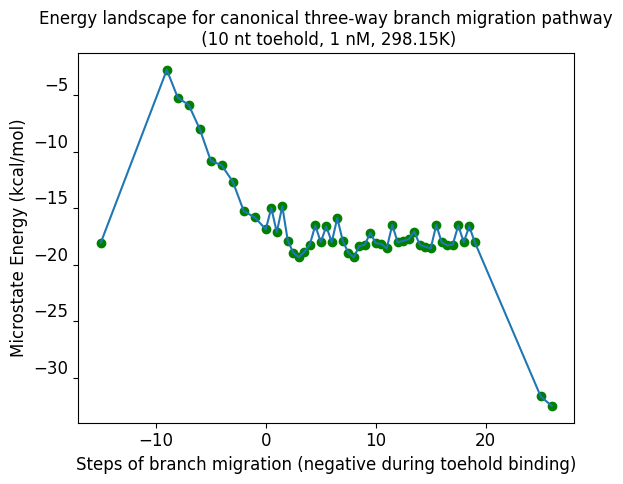

In [14]:
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(1)
plt.plot(steps,energies,'go',steps,energies,'-')
plt.title("Energy landscape for canonical three-way branch migration pathway\n (10 nt toehold, %d nM, %6.2fK)" % (o.join_concentration * 1e9, o.temperature) )
plt.xlabel("Steps of branch migration (negative during toehold binding)",fontsize='larger')
plt.ylabel("Microstate Energy (kcal/mol)",fontsize='larger')
plt.yticks(fontsize='larger',va='bottom')
plt.xticks(fontsize='larger')
plt.show()